In [1]:
using Plots, LinearAlgebra, Random
using ProgressBars
using PGFPlotsX, LaTeXStrings
pgfplotsx()

Plots.PGFPlotsXBackend()

In [2]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Barycenter_algorithms.ipynb")

barycenter_functional (generic function with 1 method)

In [3]:
function KL(X)
    d = size(X)[1]
    return (tr(X) - d - log(det(X)))/2
end

function reg_objective(sqrt_covs,X,γ)
    n = size(sqrt_covs)[3]
    return barycenter_functional(sqrt_covs, X)/2 + γ * KL(X)
end

function RGD!(covs, sqrt_covs, X, γ, ρ, nIter, times, objectives)
    d = size(covs)[1]
    n = size(covs)[3]
    
    
    T̃ = zeros(d,d)
    T = zeros(d,d)
    evals = zeros(d)
    evecs = zeros(d,d)
    
    start = time()
    for i in 1:nIter
        T .= zeros(d,d)

        for j in 1:n
            sq = @view sqrt_covs[:,:,j]

            e = eigen(Symmetric(sq*X*sq))
            evals .= e.values
            evecs .= e.vectors
            T .= T .+ sq*evecs*diagm(evals.^(-0.5))*evecs'*sq
        end
        
        T̃ .= ρ .* T./n .+ ρ .* γ .* inv(X) .+ (1 - ρ*(1+γ)) .* I(d)

        X .= Symmetric(T̃ *X *T̃)
        objectives[i] = reg_objective(sqrt_covs, X, γ)
        times[i] = time() - start
    end
end    

RGD! (generic function with 1 method)

# Prior information (Figure 4)

## Setting parameters (see paper for parameters used for figures)

In [4]:
n = 100
d = 20
nIter = 300
α = .03
β = 30
κ = β / α
perturbations = LinRange(0, 10, 10)
γs = [0 1 100]
ρs = [1/(1+2 *γ * sqrt(κ)) for γ in γs]
δ = 0.2
κ = Int(ceil((2 - δ)^2/δ^2));

In [5]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)
X = zeros(d, d)
generate_known_bary!(covs, sqrt_covs, δ)
fake_covs = zeros(d, d, n)
fake_sqrt_covs = zeros(d, d, n)
times = zeros(nIter, length(γs), length(perturbations))
placeholder = zeros(nIter)
dist = zeros(length(γs), length(perturbations))


for j in ProgressBar(1:length(perturbations))
    pert = perturbations[j]
    for i in 1:length(γs)
        γ = γs[i]
        ρ = ρs[i]
        for k in 1:n
            fake_covs[:,:,k] .= covs[:,:,k]
            fake_covs[1,1,k] += pert

            fake_sqrt_covs[:,:,k] .= fake_covs[:,:,k]^.5
        end

        X .= fake_covs[:,:,1]
        tim = @view times[:, i, j]
        RGD!(fake_covs, fake_sqrt_covs, X, γ, ρ, nIter, tim, placeholder)
        dist[i,j] = bures(I(d), X)
    end
end

0.0%┣                                           ┫ 0/10 [00:00<00:-1, -20.0 it/s]
10.0%┣████▏                                     ┫ 1/10 [00:48<Inf:Inf, 0.0 it/s]
20.0%┣████████▉                                   ┫ 2/10 [01:28<11:44, 0.0 it/s]
30.0%┣█████████████▏                              ┫ 3/10 [02:10<07:34, 0.0 it/s]
40.0%┣█████████████████▋                          ┫ 4/10 [02:52<05:45, 0.0 it/s]
50.0%┣██████████████████████                      ┫ 5/10 [03:31<04:24, 0.0 it/s]
60.0%┣██████████████████████████▍                 ┫ 6/10 [04:09<03:19, 0.0 it/s]
70.0%┣██████████████████████████████▉             ┫ 7/10 [04:50<02:25, 0.0 it/s]
80.0%┣███████████████████████████████████▏        ┫ 8/10 [05:33<01:35, 0.0 it/s]
90.0%┣███████████████████████████████████████▋    ┫ 9/10 [06:11<00:46, 0.0 it/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [06:52<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [06:52<00:00, 0.0 it/s]



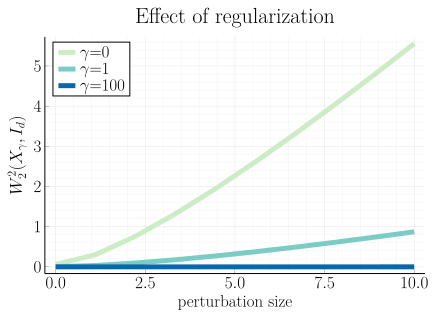

In [6]:
linecolors = [2 4 6]
plt = plot(color_palette=palette(:GnBu_6), 
    title = "Effect of regularization",
    ylabel = L"W_2^2(X_\gamma, I_d)",
    xlabel = "perturbation size",
    legend=:topleft, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
plot!(perturbations, 
    dist', 
    labels=[string("γ=", string(γ)) for γ in γs], 
    linecolors=linecolors, 
linewidth=5)

In [ ]:
savefig(plt, "./figures/effect of regularization")